
# spine recognition example using SVMs

* filetype : .npy
* filecontent: [imageslist,labelslist,imageshape]
* imageslist: [img1,img2,...]
* labelslist: [0,1,1,0,...] 0:nospine 1:spine
* imageshape: img1.shape

In [27]:
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from skimage import filters 
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter
import sys 
sys.path.append("..")
from utils.file_base import file_list



def load(f):
    """load single npy"""
    dictl=np.load(f,allow_pickle=True)
    imgs,lables,size=dictl[0],dictl[1],dictl[2]
    
    # introspect the images arrays to find the shapes (for plotting)
    n_samples, h, w = len(imgs),imgs[0].shape[0],imgs[0].shape[1]
    X = np.array([np.array(img).ravel() for img in imgs])
    n_features = h*w
    y = np.array(lables,dtype=np.int8).ravel()
    return X,y,h,w
def loads(fs):
    """load multi npys"""
    XX,yy=None,None
    for f in fs:
        X2,y2,h,w=load(f)
        if XX is not None:
            XX=np.concatenate((XX,X2),axis=0)
            yy=np.concatenate((yy,y2),axis=0)
        else:
            XX=X2
            yy=y2
    label_num= list(np.unique(yy)).sort()
    return XX,yy,label_num,h,w

def mask_balance(XX,yy):
    rus = RandomUnderSampler(random_state=0)
    """make positive/negtive sample balanced"""
    print("orisample number :",sorted(Counter(yy).items()))
    X_resampled, y_resampled = rus.fit_resample(XX, yy)
    print("resample number :",sorted(Counter(y_resampled).items()))
    return X_resampled,y_resampled
def reshape_data(XX):
    """ravel img to one dimension"""
    X=[]
    for x in XX:
        # x=filters.sobel(x)
        x=x.ravel()
        X.append(x)
    # print("img shape :",X[0].shape)
    return np.array(X)

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())    
def split_data(XX,yy):
    """Split into a training set and a test and keep 25% of the data for testing."""
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
    )
    print("Tran num ",len(y_train),"Test num ",len(y_test))
    return X_train, X_test, y_train, y_test
def show_lable_distribution(Ys,lables=None):
    cols=len(Ys)
    fig, axs = plt.subplots(ncols=cols, figsize=(10, 5))
    fig.suptitle(" partion class for dataset")
    autopct = "%.2f"
    for ax,y in zip(axs,Ys):
        def absolute_value(val):
            a  = np.round(val/100*y.shape[0], 0)
            return str(np.round(val,2))+"% : "+str(a)
        yn,ns=np.unique(y,return_counts=True)
        if lables:
            ax.pie(ns,labels=lables,counterclock=True,autopct =absolute_value)
        else:
            ax.pie(ns,labels=yn,counterclock=True,autopct = absolute_value)

set dataset directory which include .npy files.



In [10]:
# set dataset directory
TRAINDIR=r"G:\LHJ_DATA\Train\npylable2"
SAVE_model='clf.pickle'

load dataset

load dataset from : 
	 G:\LHJ_DATA\Train\npylable2\0319.npy
	G:\LHJ_DATA\Train\npylable2\0319_decon.npy
	G:\LHJ_DATA\Train\npylable2\20200724-1.npy
	G:\LHJ_DATA\Train\npylable2\20200808-2.npy
	G:\LHJ_DATA\Train\npylable2\202111-1.npy
	G:\LHJ_DATA\Train\npylable2\20211111-2.npy
	G:\LHJ_DATA\Train\npylable2\20211119-1.npy
orisample number : [(0, 2435), (1, 972)]
resample number : [(0, 972), (1, 972)]
Tran num  1458 Test num  486


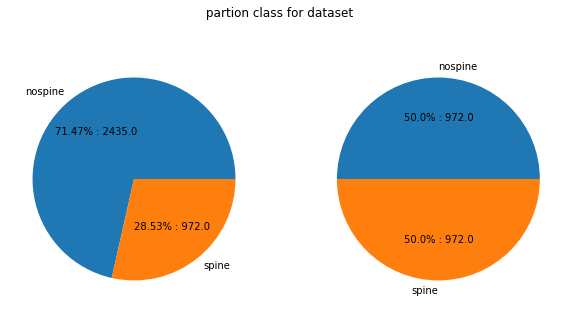

In [26]:
# load dataset
fs=file_list(TRAINDIR,"npy")
print("load dataset from : \n\t","\n\t".join(fs))
XX,yy,label_nums,h,w=loads(fs)

nn_samples=XX.shape[0]

X,y=mask_balance(XX,yy)
X=reshape_data(X)

n_samples=X.shape[0]
n_features=h*w


target_names = ["nospine","spine"]
# n_classes = len(target_names)
# print("Total dataset size:","n_samples: %d" % nn_samples)
# print("Balanced dataset size:","n_samples: %d" % n_samples)
# print("image size :%d * %d" % (h,w))
# print("n_features: %d" % n_features)
# print("n_classes: %d" % n_classes)
# print("classes name : " , ",\t".join(target_names))
# print("classes number: " , set(y))
show_lable_distribution([yy,y],target_names)
X_train, X_test, y_train, y_test=split_data(X,y)

In [28]:

scaler = Normalizer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
%matplotlib widget
#show example
plt.imshow(X_train[-17].reshape(h,w))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

fit or train

Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
dataset): unsupervised feature extraction / dimensionality reduction

Train a SVM classification model



In [21]:
n_components = 100

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Extracting the top 100 eigenfaces from 1458 faces
done in 0.114s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.004s
Fitting the classifier to the training set
done in 6.127s
Best estimator found by grid search:
SVC(C=89705.3873243953, class_weight='balanced', gamma=0.010204547967506018)


Quantitative evaluation of the model quality on the test set



Predicting people's names on the test set
done in 0.078s
              precision    recall  f1-score   support

     nospine       0.85      0.87      0.86       241
       spine       0.87      0.84      0.86       245

    accuracy                           0.86       486
   macro avg       0.86      0.86      0.86       486
weighted avg       0.86      0.86      0.86       486



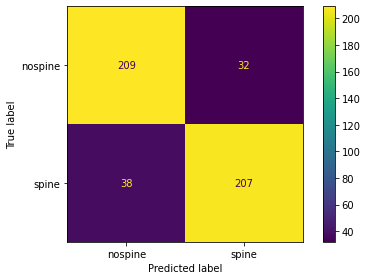

In [19]:
%matplotlib inline
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="horizontal"
)
plt.tight_layout()

plt.show()


plot the result of the prediction on a portion of the test set



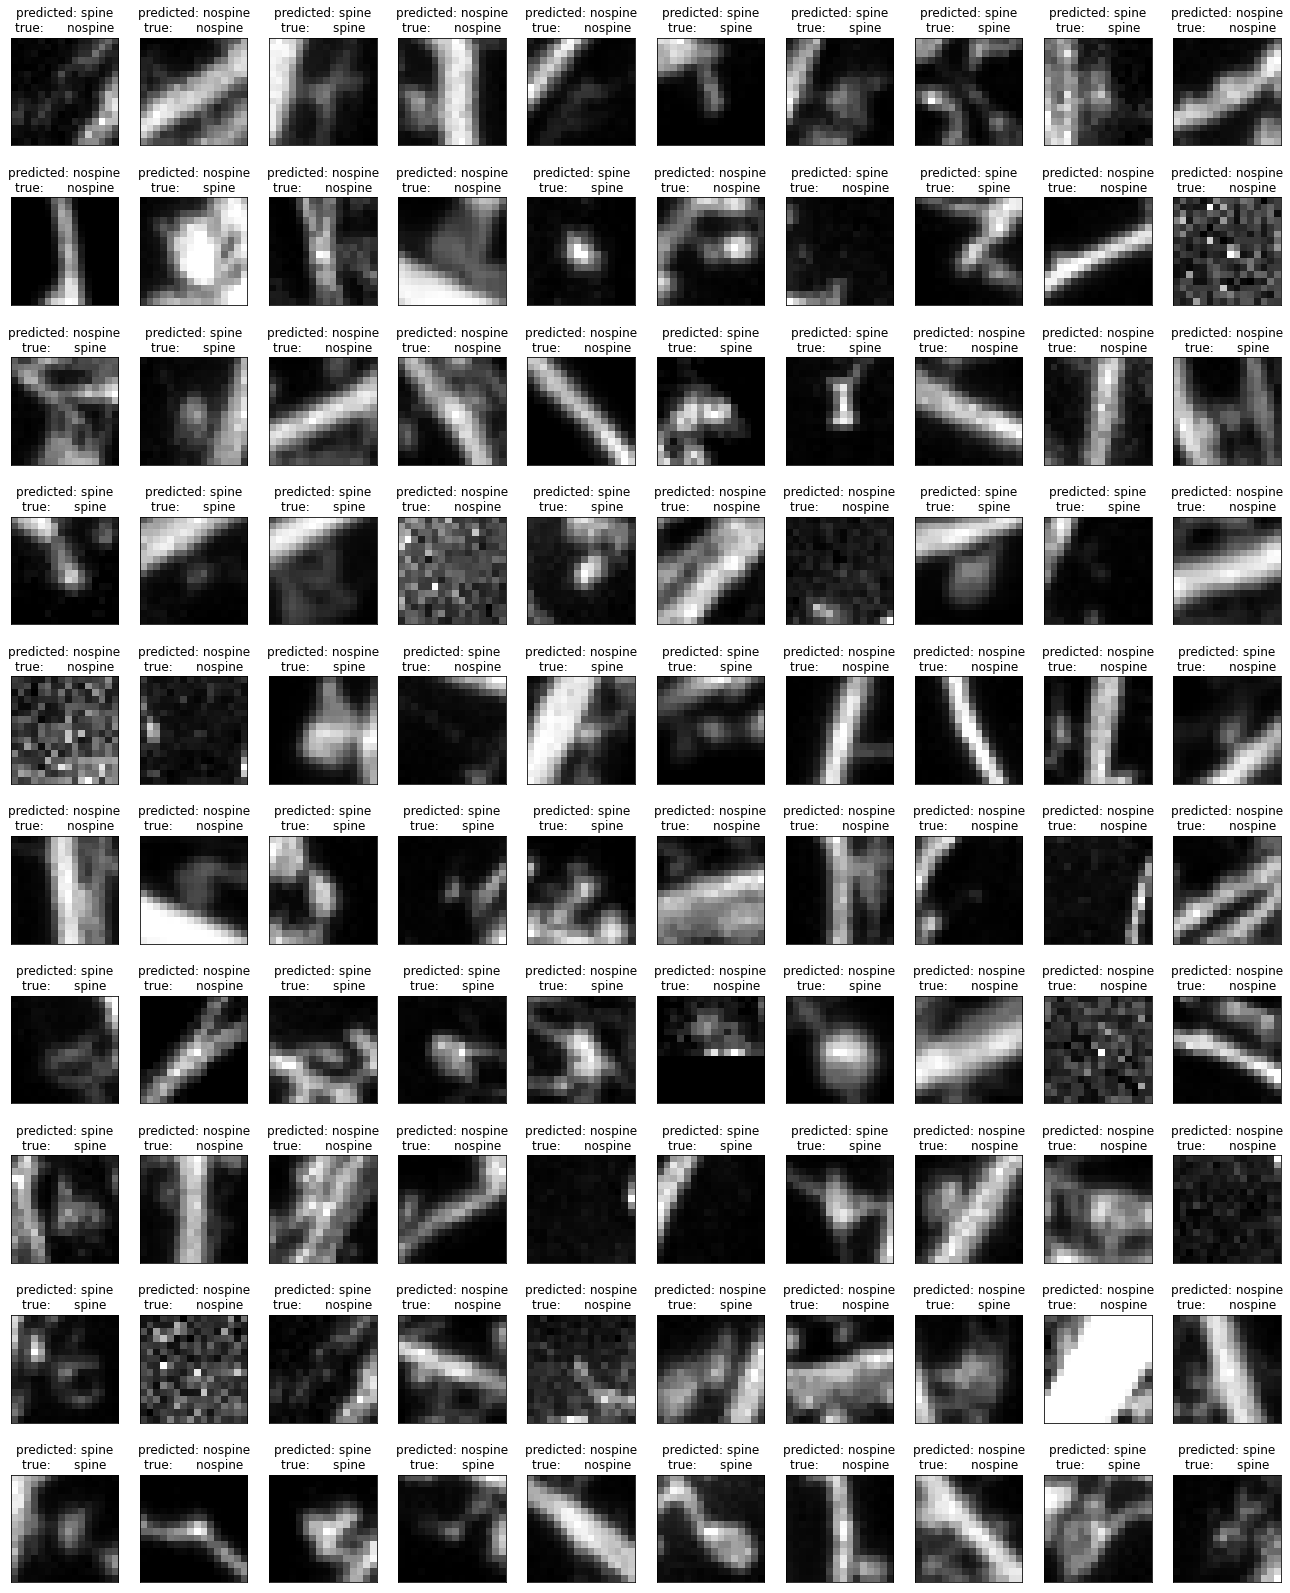

In [24]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w,10,10)

save model

In [26]:
import pickle
#保存Model(注:save文件夹要预先建立，否则会报错)
with open(SAVE_model, 'wb') as f:
    pickle.dump([clf,pca,scaler,[16,16]], f)